In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ID_Data_test = pd.read_csv('data/ID_Data_test.csv')
ID_Data_train = pd.read_csv('data/ID_Data_train.csv')
ID_Time_train = pd.read_csv('data/ID_Time_train.csv')
sample_sub_coachs = pd.read_csv('data/sample_sub_coachs.csv')
sample_submission = pd.read_csv('data/sample_sub_kaggle.csv')

ID_Data_train = ID_Data_train.sort_values(['id_race', 'id'])

In [3]:
def calc_cos(data):
    data.loc[:,'cos_angle'] = np.cos((data.loc[:,'direction_vent'] - data.loc[:,'cap'])/180 * np.pi)
    return data

def distance(lat1, lng1, lat2, lng2):
    return np.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2) 

def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

ID_Data_train = calc_cos(ID_Data_train)

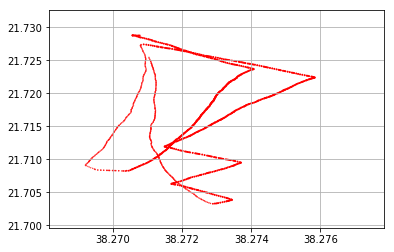

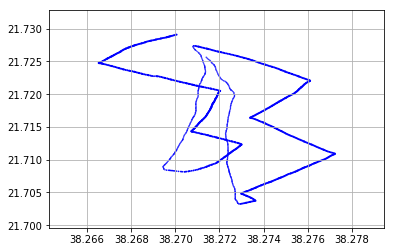

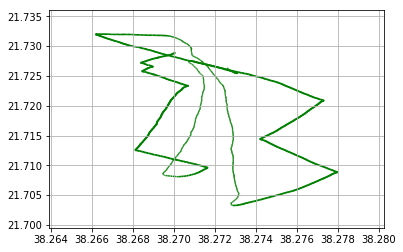

In [4]:

for color, boat in zip(['r', 'b', 'g'], ['56b4154daf1f84f7078b375715a60552',
                                         'eb94a51ccdf5f765ec8192a922289a97',
                                         'fc2131af90bc20c898089f0ffcd10c3b']):
    trajectoire = ID_Data_train.loc[(ID_Data_train['id_race'] == 'R1') & (ID_Data_train['id'] == boat), ['latitude', 'longitude']].values
    weights = ID_Data_train.loc[(ID_Data_train['id_race'] == 'R1') & (ID_Data_train['id'] == boat), 'cos_angle'].values + 1.2
    plt.scatter(trajectoire[:, 0], trajectoire[:, 1], color=color, s=weights/2)
    plt.grid()

    plt.show()

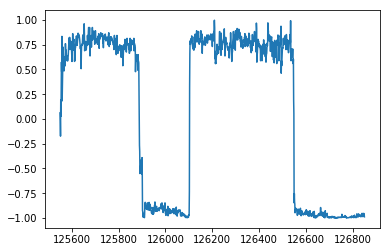

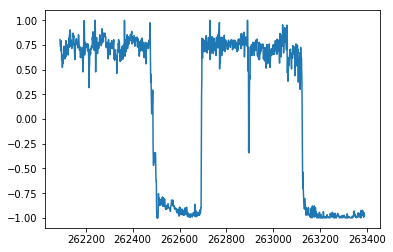

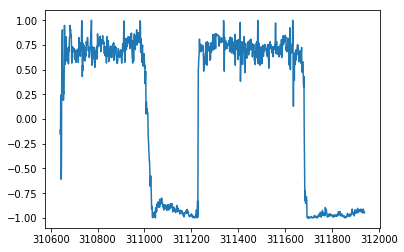

In [5]:
for boat in ID_Time_train[ID_Time_train['id_race'] == 'R1'].sort_values('temps')['id'].values[::8]:
    ID_Data_train.loc[ID_Data_train['id'] == boat, 'cos_angle'].plot()
    plt.show()

In [6]:
ID_Data_train['lat_off1'] = [0] + list(ID_Data_train['latitude'].values[:-1])
ID_Data_train['lng_off1'] = [0] + list(ID_Data_train['longitude'].values[:-1])
distance = ID_Data_train[['latitude', 'longitude', 'lat_off1', 'lng_off1']].apply(lambda row: distance(row[0], row[1], row[2], row[3]), axis=1)
ID_Data_train['distance'] = distance
ID_Data_train = ID_Data_train.drop(['lat_off1', 'lng_off1'], axis=1)

total = 0
for _, gb in ID_Data_train.groupby(['id_race', 'id']):
    ID_Data_train.iloc[total, -1] = 0
    total += gb.shape[0]

In [7]:
all_feat = list()

features = {'race' : list(),
            'boat' : list(),
            'total_dist' : list(),
            'fast_prop' : list(),
            'fast_mean' : list(),
            'fast_std' : list(),
            'fast_dist' : list(),
            'mid_prop' : list(),
            'mid_mean' : list(),
            'mid_std' : list(),
            'mid_dist' : list(),
            'slow_prop' : list(),
            'slow_mean' : list(),
            'slow_std' : list(),
            'slow_dist' : list()}
            

races = list()
boats = list()

for race, gb_race in ID_Data_train.groupby('id_race'):
    feats = list()
    for boat, gb_boat in gb_race.groupby('id'):
        cos = gb_boat['cos_angle'].values
        distance = gb_boat['distance'].values
        features['race'].append(race)
        features['boat'].append(boat)
    
        fast = cos > 0.5
        mid = ((-0.5 > cos) * (cos < 0.5)).astype(bool)
        slow = cos < -0.5

        total_dist = sum(distance)
        features['total_dist'].append(total_dist)
        
        features['fast_prop'].append(fast.mean())
        features['fast_mean'].append(cos[fast].mean())
        features['fast_std'].append(cos[fast].std())
        features['fast_dist'].append(distance[fast].sum())

        features['mid_prop'].append(mid.mean())
        features['mid_mean'].append(cos[mid].mean())
        features['mid_std'].append(cos[mid].std())
        features['mid_dist'].append(distance[mid].sum())

        features['slow_prop'].append(slow.mean())
        features['slow_mean'].append(cos[slow].mean())
        features['slow_std'].append(cos[slow].std())
        features['slow_dist'].append(distance[slow].sum())
        
features_df = pd.DataFrame(features)

C:\Users\Etienne\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\Etienne\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less
C:\Users\Etienne\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


In [8]:
features_used = ['total_dist', 'fast_prop', 'mid_prop', 'slow_prop', 'fast_dist', 'mid_dist', 'slow_dist']
X = features_df.sort_values(['race', 'boat'])[[feat for feat in features_used]].values
y = ID_Time_train.sort_values(['id_race', 'id'])['temps'].values

# récupération index de la course
split = ID_Time_train.groupby(['id_race', 'id']).count().reset_index()['id_race'].apply(lambda x: int(x[1:])).values

In [9]:
import xgboost as xgb
from tqdm import tqdm

ground_truth = list()
predictions = list()

with tqdm(total=len(set(split))) as pbar:
    for race in set(split):
        X_test = X[split == race]
        y_test = y[split == race]
        X_train = X[split != race]
        y_train = y[split != race]

        model = xgb.XGBRegressor()
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)

        ground_truth.extend(y_test)
        predictions.extend(prediction)
        
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.08it/s]


In [10]:
ground_truth = np.array(ground_truth)
predictions = np.array(predictions)

In [11]:
result = pd.DataFrame({'ground_truth': ground_truth, 'prediction': predictions, 'race': split})
result['gt_rank'] = np.concatenate([np.where(np.isin(result.loc[result['race'] == 1]['ground_truth'].sort_values().index.values, n))[0][0]
                                    for n in range(sum(result['race'] == 1))]
                                       for race in result['race'].unique()])
result['pred_rank'] = np.concatenate([result.loc[result['race'] == race]['prediction'].argsort().values for race in result['race'].unique()])

SyntaxError: invalid syntax (<ipython-input-11-fdf390cffcf9>, line 4)

<Container object of 7 artists>

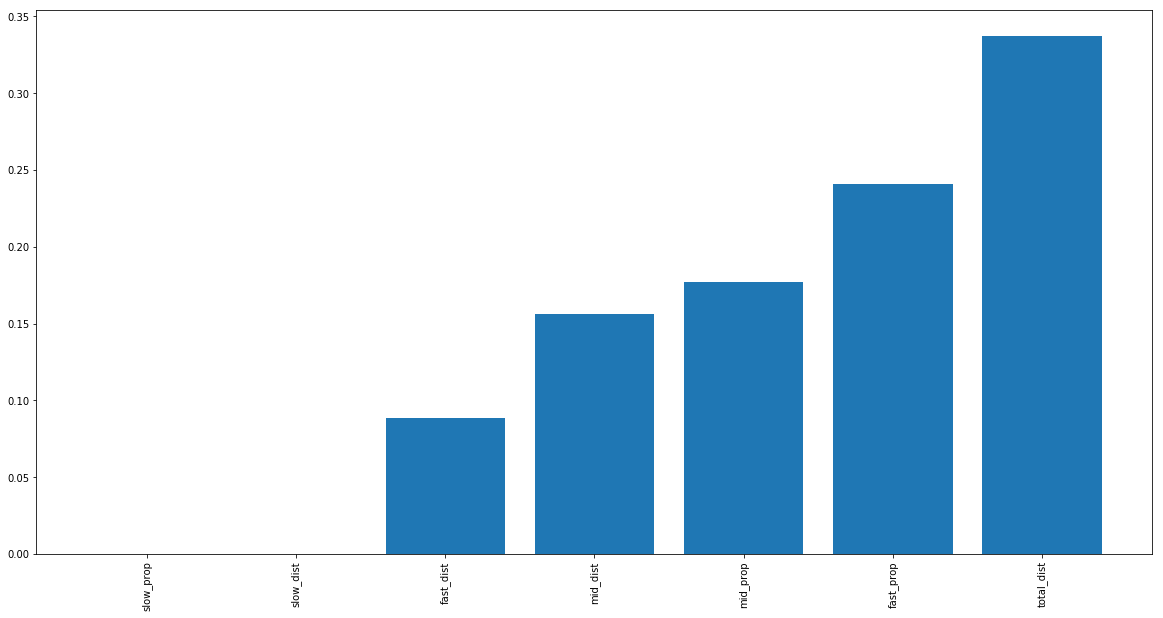

In [12]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

plt.bar(range(len(model.feature_importances_)),
        sorted(model.feature_importances_),
        tick_label=np.array(features_used)[np.argsort(model.feature_importances_)])